# Кодирование и нормализация признаков

На данном этапе подготовим данные для подачи их в модель машинного обучения

In [134]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import numpy as np
import re
import statistics as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from scipy.stats import shapiro, normaltest 
import sklearn.metrics as metrics
from sklearn import feature_selection
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
import optuna

<ipython-input-2-08862bdf32ce>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #установка стиля matplotlib


In [135]:
data = pd.read_csv('data/data_cleaned.csv')
data.describe()

,baths,fireplace,sqft,zipcode,stories,target,year_built,heating,cooling,parking,private_pool,school_rating,school_min_distance,beds_area,baths_area,lotsize_sqft
count,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,3.114990e+05,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000,311499.000000
mean,2.639026,0.303535,2133.169193,52814.419282,0.862722,5.534103e+05,1980.717267,0.767784,0.715774,0.535819,0.132601,5.168097,1.035144,649.081101,813.404746,13328.026848
std,1.336041,0.459785,1232.017845,26762.249515,1.026193,7.823387e+05,32.434354,0.422247,0.451046,0.498716,0.339143,1.927178,1.408655,219.191253,244.190094,24371.686678
min,1.000000,0.000000,333.000000,1103.000000,0.000000,9.900000e+03,1800.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,219.833333,312.363636,229.000000
25%,2.000000,0.000000,1314.000000,33056.000000,0.000000,2.149000e+05,1959.000000,1.000000,0.000000,0.000000,0.000000,3.700000,0.360000,500.000000,648.000000,4426.000000
50%,2.000000,0.000000,1845.000000,37406.000000,1.000000,3.350000e+05,1988.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.630000,613.333333,790.000000,7405.000000
75%,3.000000,1.000000,2571.000000,77845.000000,1.000000,5.790000e+05,2006.000000,1.000000,1.000000,1.000000,0.000000,6.500000,1.200000,751.687500,931.000000,11325.600000
max,24.000000,1.000000,10818.000000,99338.000000,3.000000,1.000000e+07,2022.000000,1.000000,1.000000,1.000000,1.000000,10.000000,26.670000,2076.400000,2277.000000,244589.400000


### Кодирование признаков

Строить модели будем на двух вариантах выборки: 1 - с исходными данными, 2 - с логарифмированными непрерывными числовыми признаками.
Хотя и статистические тесты показали нам, что распределения признаков не является нормальным, но визуально оно очень близко к этому. Я считаю, что такой метод позволит при моделировании добиться более высоких позакателей в метриках.

In [136]:
# Делаем копию датасета с исходными данными
data_coded = data.copy()

# Делаем вторую копию, в которой прологарифмируем числовые непрерывные признаки (кроме целевого)
data_log_coded = data_coded.copy()
for column in ['sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft']:
    data_log_coded[column] = np.log(data_log_coded[column])
data_log_coded[column] = np.log(data_log_coded['school_min_distance']+1)

Большинство моделей машинного обучения умеет работать только на числовых признаках без пропусков. Преобразование (кодирование) данных в такой формат очень тонкий и важный этап работы.
При определении способа кодирования придерживаемся следующего принципа:
- непрерывные числовые признаки кодировать не нужно;
- порядковые и бинарные признаки нужно кодировать способом Ordinal Encoding;
- категориальные признаки с небольшим числом значений - способом OneHot Encoding;
- категориальные признаки с большим числом значений - способом Binary Encoding.

На практике мною было опробовано 7 вариантов кодирования данных (все опробованные варианты сохранил в файле coded_features.ipynb). Продемонстрировать прверку эффективности каждого из способов кодировки я не могу, поскольку над каждым набором кодированных данных проводил множество вариаций преобразований вплоть до построения моделей различных типов с подбором гиперпараметров, подсчетом и сравнением метрик.

По итогам экспериментов выбрал как наиболее эффективный для данного набора данных алгоритм кодирования - Sample 5.

In [137]:
# Sample 5 - 61 features

label_list = ['baths', 'stories', 'year_built', 'zipcode'] # порядковые признаки, в т.ч. и не совсем объяснимо зипкод
onehot_cat_list = ['status', 'property_add_type', 'state'] # категориальные признаки

# Кодируем признаки 1-го набора данных
label_encoder = LabelEncoder()
for column in label_list:
    data_coded[column] = label_encoder.fit_transform(data_coded[[column]])
data_coded = pd.get_dummies(data_coded)

# Кодируем признаки 2-го набора данных
label_encoder = LabelEncoder()
for column in label_list:
    data_log_coded[column] = label_encoder.fit_transform(data_log_coded[[column]])
data_log_coded = pd.get_dummies(data_log_coded)

display(data_coded.head())
display(data_log_coded.head())

,baths,fireplace,sqft,zipcode,stories,target,year_built,heating,cooling,parking,private_pool,school_rating,school_min_distance,beds_area,baths_area,lotsize_sqft,status_active,status_foreclosure,status_new,status_pre_foreclosure,status_under_contract,state_AZ,state_CA,state_CO,state_DC,state_FL,state_GA,state_IA,state_IL,state_IN,state_MA,state_MD,state_ME,state_MI,state_MO,state_NC,state_NJ,state_NV,state_NY,state_OH,state_OR,state_PA,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,property_add_type_attached,property_add_type_carriage,property_add_type_co op,property_add_type_condo,property_add_type_cottage,property_add_type_custom,property_add_type_detached,property_add_type_log,property_add_type_mobile,property_add_type_patio,property_add_type_ranch,property_add_type_split
0,3,1,2900.0,838,1,418000,202,1,0,0,0,5.2,2.70,725.0,828.571429,27878.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,0,1947.0,4033,1,310000,202,0,0,0,0,4.0,1.01,649.0,649.000000,5828.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,3000.0,3192,0,2895000,144,1,1,1,1,6.7,1.19,1000.0,1500.000000,8626.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,7,1,6457.0,2291,2,2395000,189,1,1,1,0,9.2,0.10,1291.4,807.125000,8220.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,897.0,524,1,209000,103,1,1,0,0,5.0,0.63,448.5,596.739356,680.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


,baths,fireplace,sqft,zipcode,stories,target,year_built,heating,cooling,parking,private_pool,school_rating,school_min_distance,beds_area,baths_area,lotsize_sqft,status_active,status_foreclosure,status_new,status_pre_foreclosure,status_under_contract,state_AZ,state_CA,state_CO,state_DC,state_FL,state_GA,state_IA,state_IL,state_IN,state_MA,state_MD,state_ME,state_MI,state_MO,state_NC,state_NJ,state_NV,state_NY,state_OH,state_OR,state_PA,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,property_add_type_attached,property_add_type_carriage,property_add_type_co op,property_add_type_condo,property_add_type_cottage,property_add_type_custom,property_add_type_detached,property_add_type_log,property_add_type_mobile,property_add_type_patio,property_add_type_ranch,property_add_type_split
0,3,1,7.972466,838,1,418000,202,1,0,0,0,1.648659,2.70,6.586172,6.719703,1.308333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,0,7.574045,4033,1,310000,202,0,0,0,0,1.386294,1.01,6.475433,6.475433,0.698135,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,1,8.006368,3192,0,2895000,144,1,1,1,1,1.902108,1.19,6.907755,7.313220,0.783902,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,7,1,8.772920,2291,2,2395000,189,1,1,1,0,2.219203,0.10,7.163482,6.693479,0.095310,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,6.799056,524,1,209000,103,1,1,0,0,1.609438,0.63,6.105909,6.391480,0.488580,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Разбиение выборки, нормализация данных

Оба набора данных разобьем на выборки train и test в пропорции 80/20.

После кодирования в датасете появился 61 признак. Это, конечно, многовато. С помощью инструмента SelectKBest я протестировал работу моделей на разных наборах признаков (в том числе и самый популярный - 25 лучших). Но экспериментальным путем установил, что  метрики начинают падать, если брать в модель меньше 56 признаков, поэтому решил остановиться на данном числе.

Согласно результатов статистических тестов, распределения наших признаков не являются нормальными, поэтому для нормализации будем использовать метод RobustScaler.

In [138]:
# 1-й набор данных

# Разбиваем выборку на train и test, задаем векторы правильных ответов
X = data_coded.drop(['target'], axis=1)
y = data_coded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Выберем лучших 56 признаков для модели
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=56)
selector.fit(X_train, y_train)
best_features = selector.get_feature_names_out()
X_train, X_test = X_train[best_features], X_test[best_features]

# Выполним нормализацию данных
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [139]:
# 2-й набор данных

# Разбиваем логарифмированную выборку на train и test, задаем векторы правильных ответов
X_log = data_log_coded.drop(['target'], axis=1)
y_log = data_log_coded['target']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.20, random_state=42)

# Выберем лучших 56 признаков для модели
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=56)
selector.fit(X_train_log, y_train_log)
best_features_log = selector.get_feature_names_out()
X_train_log, X_test_log = X_train_log[best_features_log], X_test_log[best_features_log]

#Создаем объект для нормализации, вычисляем параметры, производим преобразование для каждой из выборок
scaler = RobustScaler()
scaler.fit(X_train_log)
X_train_log_scaled = scaler.transform(X_train_log)
X_test_log_scaled = scaler.transform(X_test_log)

# Моделирование

На данном этапе определим модели, наиболее подходящие для решения поставленной задачи регрессии (предсказание стоимости недвижимости). Определимся с метриками, которыми будем оценивать эффективность моделей. Построим модели различного типа и выберем наиболее эффективную.

## Метрики

Для оценки качества решения задачи регрессии существует множество метрик. Мы будем использовать следующие:
1. **MAE (Mean Absolute Error)** - средняя абсолютная ошибка. Показывает среднее арифметическое модуля отклонения предсказанного значения от реального, легко интерпритировать результат (чем меньше, тем лучше).
2. **MAPE (Mean Absolute Percent Error)** - средняя абсолютная ошибка в процентах. Показывает, на сколько процентов в среднем наше предсказание отклоняется от реального значения.
3. **R2** - коэффициент детерминации. Показывает, насколько наша модель лучше, чем если бы все предсказания были средним по правильным ответам; описывает, какую долю информации о зависимости (дисперсии) смогла уловить модель. 


In [140]:
# Добавим функцию для вывода метрик
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))

## Baseline

В качестве базовой модели (baseline) возьмем простую идею, что цена прямо зависит от жилплощади продаваемого объекта. 

За предсказание возьмем произведение жилплощади на условный коэффициент k (отношение медианой цены объектов в датасете к медиане жилплощади).

In [141]:
# Разделим некодированную выборку на train и test 
X_base = data.drop(['target'], axis=1)
y_base = data['target']
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.20, random_state=42) 

# Вычислим условный коэффициент k
k = data['target'].median() / data['sqft'].median()

# Формируем предсказание
y_train_base_pred = X_train_base['sqft'] * k
y_test_base_pred = X_test_base['sqft'] * k

print_metrics(y_train_base, y_train_base_pred, y_test_base, y_test_base_pred)

Train MAE: 302986.049
Train MAPE: 72.624
Train R^2: 0.166
Test MAE: 300703.874
Test MAPE: 72.206
Test R^2: 0.169


Результат далек от идеала, но для такой элементарной модели очень даже ничего - погрешность прогноза 72%, но коэффициент детерминации ~ 0.16, что говорит о том, что закономерности в данных модель практически не уловила. 

## Простые модели

### Линейная регрессия

In [142]:
# Cоздаём объект класса линейной регрессии и обучаем модель 
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Формируем предсказание
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

print_metrics(y_train, lr_train_pred, y_test, lr_test_pred)

Train MAE: 302649.576
Train MAPE: 103.326
Train R^2: 0.438
Test MAE: 299997.372
Test MAPE: 101.807
Test R^2: 0.439


Видим, что по метрике MAPE предсказание даже хуже, чем baseline. При этом модель все же уловила какие-то зависимости в данных, метрика R2 стала заметно выше.  

In [143]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Cоздаём объект класса линейной регрессии и обучаем модель
lr_log_model = LinearRegression()
lr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
lr_log_train_pred = np.exp(lr_log_model.predict(X_train_log_scaled))
lr_log_test_pred = np.exp(lr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, lr_log_train_pred, y_test_log, lr_log_test_pred)

Train MAE: 231427.590
Train MAPE: 50.179
Train R^2: 0.463
Test MAE: 230314.077
Test MAPE: 49.546
Test R^2: 0.457


Модель линейной регрессии, построенная на логарифмированных признаках, показывает вдвое лучший результат. Метрика MAPE улучшилась до 49.5%, да и R2 еще немного подрос.

### Полиномиальная линейная регрессия

Для модели полиноминальной регрессии придется заново переразбить выборку и отобрать в модель меньший набор факторов. Проблема в том, что при генерации полиномиальных признаков 56 уже отобранных факторов превратятся в 1652 новых и на обучение модели потребуются колоссальные вычислительные мощности. Сократим число исходных факторов до 35 (сгенерируется 665 новых признаков).

In [144]:
# Разбиваем выборку на train и test, задаем векторы правильных ответов
X_poly = data_coded.drop(['target'], axis=1)
y_poly = data_coded['target']
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.20, random_state=42)

# С помощью инструмента SelectKBest отберем 35 лучших признаков
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=35)
selector.fit(X_train_poly, y_train_poly)
best_features = selector.get_feature_names_out()
X_train_poly, X_test_poly = X_train_poly[best_features], X_test_poly[best_features]

#Создаем объект для нормализации, вычисляем параметры, производим преобразование для каждой из выборок
scaler = RobustScaler()
scaler.fit(X_train_poly)
X_train_scaled_poly = scaler.transform(X_train_poly)
X_test_scaled_poly = scaler.transform(X_test_poly)

In [145]:
# Создаем объект для генерации полиномиальных признаков, вычисляем параметры (число признаков)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled_poly)

#Производим преобразование для каждой из выборок
X_train_poly = poly.transform(X_train_scaled_poly)
X_test_poly = poly.transform(X_test_scaled_poly)

# Cоздаём объект класса линейной регрессии и обучаем модель
lr_poly_model = LinearRegression()
lr_poly_model.fit(X_train_poly, y_train_poly)

# Формируем предсказание
lr_poly_train_pred = lr_poly_model.predict(X_train_poly)
lr_poly_test_pred = lr_poly_model.predict(X_test_poly)

print_metrics(y_train_poly, lr_poly_train_pred, y_test_poly, lr_poly_test_pred)

Train MAE: 241132.568
Train MAPE: 63.680
Train R^2: 0.586
Test MAE: 241447.414
Test MAPE: 62.702
Test R^2: 0.573


Построим такую же модель для данных с логарифмированными признаками

In [146]:
# Разбиваем выборку на train и test, задаем векторы правильных ответов
X_log_poly = data_log_coded.drop(['target'], axis=1)
y_log_poly = data_log_coded['target']
X_train_log_poly, X_test_log_poly, y_train_log_poly, y_test_log_poly = train_test_split(X_log_poly, y_log_poly, test_size=0.20, random_state=42)

# С помощью инструмента SelectKBest отберем 35 лучших признаков
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=35)
selector.fit(X_train_log_poly, y_train_log_poly)
best_features_log = selector.get_feature_names_out()
X_train_log_poly, X_test_log_poly = X_train_log_poly[best_features], X_test_log_poly[best_features]

#Создаем объект для нормализации, вычисляем параметры, производим преобразование для каждой из выборок
scaler = RobustScaler()
scaler.fit(X_train_log_poly)
X_train_log_poly_scaled = scaler.transform(X_train_log_poly)
X_test_log_poly_scaled = scaler.transform(X_test_log_poly)

In [147]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Создаем объект для генерации полиномиальных признаков, вычисляем параметры (число признаков)
poly_log = PolynomialFeatures(degree=2, include_bias=False)
poly_log.fit(X_train_log_poly_scaled)

#Производим преобразование для каждой из выборок
X_train_log_poly = poly.transform(X_train_log_poly_scaled)
X_test_log_poly = poly.transform(X_test_log_poly_scaled)

# Cоздаём объект класса линейной регрессии и обучаем модель
lr_poly_log_model = LinearRegression()
lr_poly_log_model.fit(X_train_log_poly, np.log(y_train_log_poly))

# Формируем предсказание
lr_poly_log_train_pred = np.exp(lr_poly_log_model.predict(X_train_log_poly))
lr_poly_log_test_pred = np.exp(lr_poly_log_model.predict(X_test_log_poly))

print_metrics(y_train_log_poly, lr_poly_log_train_pred, y_test_log_poly, lr_poly_log_test_pred)

Train MAE: 212131.276
Train MAPE: 42.291
Train R^2: 0.536
Test MAE: 212403.054
Test MAPE: 41.806
Test R^2: 0.515


Видим, что полиномиальная регрессия отрабатывает лучше обычной (хотя она более ресурсозатратна). Лучший результат снова показывает модель, построенная на логарифмированных признаках - MAPE на тестовой выборке 41.8%, R2 - 0.515 (значения больше 0.5 уже считается удовлетворительными), переобучения практически нет.

### Дерево решений

Построим решающие деревья без подбора параметров

In [148]:
# Cоздаём объект класса решающего дерева и обучаем модель
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(X_train_scaled, y_train)

# Формируем предсказание
dtr_train_pred = dtr_model.predict(X_train_scaled)
dtr_test_pred = dtr_model.predict(X_test_scaled)

print_metrics(y_train, dtr_train_pred, y_test, dtr_test_pred)

Train MAE: 1033.365
Train MAPE: 0.216
Train R^2: 0.999
Test MAE: 167907.783
Test MAPE: 35.150
Test R^2: 0.601


In [149]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Cоздаём объект класса решающего дерева и обучаем модель
dtr_log_model = DecisionTreeRegressor(random_state=42)  
dtr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
dtr_log_train_pred = np.exp(dtr_log_model.predict(X_train_log_scaled))
dtr_log_test_pred = np.exp(dtr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, dtr_log_train_pred, y_test_log, dtr_log_test_pred)

Train MAE: 1144.628
Train MAPE: 0.219
Train R^2: 0.999
Test MAE: 170747.341
Test MAPE: 34.733
Test R^2: 0.578


Налицо явное переобучение. Попробуем подобрать оптимальные параметры моделей с помощью GridSearchCV.

In [150]:
param_grid = {
    'max_depth': range(5, 15, 2),
    'min_samples_leaf': range(2, 10, 2)}

grid_search = GridSearchCV(
    estimator=dtr_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1)

grid_search.fit(X_train, y_train)

dtr_best_params = grid_search.best_params_
dtr_best_params

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'max_depth': 13, 'min_samples_leaf': 8}

In [151]:
param_grid = {
    'max_depth': range(5, 15, 2),
    'min_samples_leaf': range(2, 10, 2)}

grid_search = GridSearchCV(
    estimator=dtr_log_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1)

grid_search.fit(X_train_log, y_train_log)

dtr_log_best_params = grid_search.best_params_
dtr_log_best_params

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'max_depth': 13, 'min_samples_leaf': 6}

Заново построим модели, используя подобранные параметры

In [152]:
# Cоздаём объект класса решающего дерева и обучаем модель
dtr_model = DecisionTreeRegressor(max_depth=13, min_samples_leaf=8, random_state=42)
dtr_model.fit(X_train_scaled, y_train)

# Формируем предсказание
dtr_train_pred = dtr_model.predict(X_train_scaled)
dtr_test_pred = dtr_model.predict(X_test_scaled)

print_metrics(y_train, dtr_train_pred, y_test, dtr_test_pred)

Train MAE: 173210.584
Train MAPE: 46.606
Train R^2: 0.782
Test MAE: 193274.748
Test MAPE: 48.713
Test R^2: 0.666


In [153]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Cоздаём объект класса решающего дерева и обучаем модель
dtr_log_model = DecisionTreeRegressor(max_depth=13, min_samples_leaf=6, random_state=42)  
dtr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
dtr_log_train_pred = np.exp(dtr_log_model.predict(X_train_log_scaled))
dtr_log_test_pred = np.exp(dtr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, dtr_log_train_pred, y_test_log, dtr_log_test_pred)

Train MAE: 160430.406
Train MAPE: 32.707
Train R^2: 0.760
Test MAE: 184190.184
Test MAPE: 36.045
Test R^2: 0.638


Метрики подросли, переобучение минимальное. На данный момент лучший результат показывает модель решающего дерева, построенного на логарифмированных числовых и целевом признаках. Ошибка на тестовой выборке 36% от верного ответа, при этом модель неплохо улавливает зависимости в данных (R2 на тестовой выборке составляет 0.638).

Модель проще и эффективнее полиномиальной линейной регрессии, но результат все еще слабоват. Попробуеем более сложные модели.

## Ансамблевые методы

Основная идея ансамблевых методов заключается в улучшении качества слабых (базовых) моделей путем обучения моделей для решения одной и той же поставленной задачи с последующим объединением и получением некоторого более сильного и стабильного консенсус-решения.

### Адаптивный бустинг

Построим ансамбли адаптивного бустинга над деревьями решений с параметрами по умолчанию

In [154]:
# Создаем объект класса дерева решений
dtr_model = DecisionTreeRegressor(random_state=42)

# Создаем объект класса AdaBoost и обучаем модель
ab_model = AdaBoostRegressor(estimator=dtr_model, random_state=42)
ab_model.fit(X_train_scaled, y_train)

# Формируем предсказание
ab_train_pred  = ab_model.predict(X_train_scaled)
ab_test_pred  = ab_model.predict(X_test_scaled)

print_metrics(y_train, ab_train_pred, y_test, ab_test_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train MAE: 14943.849
Train MAPE: 6.690
Train R^2: 0.995
Test MAE: 123645.847
Test MAPE: 27.086
Test R^2: 0.801


In [155]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Создаем объект класса дерева решений
dtr_log_model = DecisionTreeRegressor(random_state=42)

# Создаем объект класса AdaBoost и обучаем модель
ab_log_model = AdaBoostRegressor(estimator=dtr_log_model, random_state=42)
ab_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
ab_log_train_pred  = np.exp(ab_log_model.predict(X_train_log_scaled))
ab_log_test_pred  = np.exp(ab_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, ab_log_train_pred, y_test_log, ab_log_test_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train MAE: 22634.788
Train MAPE: 3.482
Train R^2: 0.975
Test MAE: 126903.284
Test MAPE: 23.101
Test R^2: 0.762


Результат работы адаптивного бустинга лучше, чем у отдельного решающего дерева, но с параметрами по умолчанию вернулось сильное переобучение.

Также заметно, что на логарифмированных признаках метрики немного выше. Попробуем улучшить результат, подобрав оптимальные гиперпараметры для второго набора данных. Для оптимизации гиперпараметров воспользуемся библиотекой optuna.

In [156]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 5, 39, 2) 
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1) 
  n_estimators = trial.suggest_int('n_estimators', 50, 300, 25)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7, step=0.03)
  # создаем и обучаем модель
  model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42), 
                            n_estimators=n_estimators, 
                            learning_rate=learning_rate, 
                            random_state=42)
  model.fit(X_train_log_scaled, np.log(y_train_log))
  score = cross_val_score(model, X_test_log_scaled, np.log(y_test_log), cv=3, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  return abs(score)

# cоздаем объект исследования и ищем лучшую комбинацию гиперпараметров
study_ab = optuna.create_study(study_name="AdaBoostRegressor", direction="minimize")
study_ab.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_ab.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_ab.best_value))

[I 2023-10-31 14:31:16,465] A new study created in memory with name: AdaBoostRegressor
[I 2023-10-31 14:35:24,941] Trial 0 finished with value: 0.2803820957567114 and parameters: {'max_depth': 29, 'min_samples_leaf': 7, 'n_estimators': 100, 'learning_rate': 0.45999999999999996}. Best is trial 0 with value: 0.2803820957567114.
[I 2023-10-31 14:42:27,525] Trial 1 finished with value: 0.3313099419803086 and parameters: {'max_depth': 21, 'min_samples_leaf': 10, 'n_estimators': 300, 'learning_rate': 0.61}. Best is trial 0 with value: 0.2803820957567114.
[I 2023-10-31 14:50:41,133] Trial 2 finished with value: 0.2999659220642108 and parameters: {'max_depth': 13, 'min_samples_leaf': 3, 'n_estimators': 225, 'learning_rate': 0.22}. Best is trial 0 with value: 0.2803820957567114.
[I 2023-10-31 14:58:49,300] Trial 3 finished with value: 0.272935918877486 and parameters: {'max_depth': 35, 'min_samples_leaf': 2, 'n_estimators': 225, 'learning_rate': 0.28}. Best is trial 3 with value: 0.272935918877

Наилучшие значения гиперпараметров {'max_depth': 39, 'min_samples_leaf': 3, 'n_estimators': 50, 'learning_rate': 0.31}
MAPE на тестовом наборе: 0.27


In [157]:
# Выполним еще 10 итераций подбора гиперпараметров
study_ab.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_ab.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_ab.best_value))

[I 2023-10-31 15:37:34,334] Trial 10 finished with value: 0.2664296734972856 and parameters: {'max_depth': 39, 'min_samples_leaf': 1, 'n_estimators': 50, 'learning_rate': 0.04}. Best is trial 10 with value: 0.2664296734972856.
[I 2023-10-31 15:41:59,141] Trial 11 finished with value: 0.266723325654365 and parameters: {'max_depth': 39, 'min_samples_leaf': 1, 'n_estimators': 50, 'learning_rate': 0.01}. Best is trial 10 with value: 0.2664296734972856.
[I 2023-10-31 15:46:22,364] Trial 12 finished with value: 0.2664296734972856 and parameters: {'max_depth': 39, 'min_samples_leaf': 1, 'n_estimators': 50, 'learning_rate': 0.04}. Best is trial 10 with value: 0.2664296734972856.
[I 2023-10-31 15:50:46,115] Trial 13 finished with value: 0.26298855471807775 and parameters: {'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 50, 'learning_rate': 0.13}. Best is trial 13 with value: 0.26298855471807775.
[I 2023-10-31 15:56:45,431] Trial 14 finished with value: 0.26222094156153797 and parameter

Наилучшие значения гиперпараметров {'max_depth': 33, 'min_samples_leaf': 3, 'n_estimators': 100, 'learning_rate': 0.13}
MAPE на тестовом наборе: 0.26


Построим модель, используя подобранные параметры


In [174]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Создаем объект класса дерева решений
dtr_log_model = DecisionTreeRegressor(max_depth=33, min_samples_leaf=3, random_state=42)

# Создаем объект класса AdaBoost и обучаем модель
ab_log_model = AdaBoostRegressor(estimator=dtr_log_model, n_estimators=100, learning_rate=0.13, random_state=42)
ab_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
ab_log_train_pred  = np.exp(ab_log_model.predict(X_train_log_scaled))
ab_log_test_pred  = np.exp(ab_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, ab_log_train_pred, y_test_log, ab_log_test_pred)

Train MAE: 34690.681
Train MAPE: 5.682
Train R^2: 0.982
Test MAE: 117589.925
Test MAPE: 21.542
Test R^2: 0.796


Optuna - мощный инструмент, но пока что побороть переобуение он нам не помог, разница в MAPE на train и test выборках почти 16%.
Конечно, метрики сейчас кажутся хорошими, но если проболжать работу с адаптивным бустингом и искать точку баланса с минимальным переобучением, то тестовые метрики однозначно снизятся, возможно, что существенно.

Пока попробуем другие ансамблевые алгоритмы и будем сравнивать уже все их вместе.

### Градиентный бустинг

Построим ансамбли градиентного бустинга над деревьями решений с параметрами по умолчанию

In [159]:
# Создаем объект класса градиентный бустинг и обучаем модель
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train_scaled, y_train)

# Формируем предсказание
gbr_train_pred  = gbr_model.predict(X_train_scaled)
gbr_test_pred  = gbr_model.predict(X_test_scaled)

print_metrics(y_train, gbr_train_pred, y_test, gbr_test_pred)

Train MAE: 210757.392
Train MAPE: 55.979
Train R^2: 0.645
Test MAE: 209366.632
Test MAPE: 54.954
Test R^2: 0.631


In [160]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Создаем объект класса градиентный бустинг и обучаем модель
gbr_log_model = GradientBoostingRegressor(random_state=42)
gbr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
gbr_log_train_pred  = np.exp(gbr_log_model.predict(X_train_log_scaled))
gbr_log_test_pred  = np.exp(gbr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, gbr_log_train_pred, y_test_log, gbr_log_test_pred)

Train MAE: 197355.879
Train MAPE: 39.119
Train R^2: 0.571
Test MAE: 196826.337
Test MAPE: 38.787
Test R^2: 0.566


Пока что результат не впечатляет. Видим, что на логарифмированных признаках, алгоритм работает лучше, переобучения нет. Но даже простое дерево решений показало результат лучше. 

Попробуем улучшить результат, подобрав оптимальные гиперпараметры для второго набора данных.

In [161]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 300, 25)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7, step=0.03)
  max_depth = trial.suggest_int('max_depth', 5, 39, 2)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем и обучаем модель
  model = GradientBoostingRegressor(n_estimators=n_estimators, 
                                    learning_rate=learning_rate, 
                                    max_depth=max_depth, 
                                    min_samples_leaf=min_samples_leaf, 
                                    random_state=42)
  model.fit(X_train_log_scaled, np.log(y_train_log))
  score = cross_val_score(model, X_test_log_scaled, np.log(y_test_log), cv=3, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  return abs(score)

# cоздаем объект исследования и ищем лучшую комбинацию гиперпараметров
study_gbr = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize")
study_gbr.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_gbr.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_gbr.best_value))

[I 2023-10-31 16:35:59,584] A new study created in memory with name: GradientBoostingRegressor
[I 2023-10-31 16:41:20,667] Trial 0 finished with value: 0.2868278968853489 and parameters: {'n_estimators': 200, 'learning_rate': 0.64, 'max_depth': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.2868278968853489.
[I 2023-10-31 17:01:46,833] Trial 1 finished with value: 0.32219197468970745 and parameters: {'n_estimators': 200, 'learning_rate': 0.64, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2868278968853489.
[I 2023-10-31 17:20:20,650] Trial 2 finished with value: 0.2738096316345595 and parameters: {'n_estimators': 150, 'learning_rate': 0.25, 'max_depth': 37, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.2738096316345595.
[I 2023-10-31 17:27:11,012] Trial 3 finished with value: 0.25169189134082126 and parameters: {'n_estimators': 200, 'learning_rate': 0.06999999999999999, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.251

Наилучшие значения гиперпараметров {'n_estimators': 200, 'learning_rate': 0.06999999999999999, 'max_depth': 9, 'min_samples_leaf': 2}
MAPE на тестовом наборе: 0.25


In [162]:
# Выполним еще 10 итераций подбора гиперпараметров
study_gbr.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_gbr.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_gbr.best_value))

[I 2023-10-31 19:04:46,984] Trial 10 finished with value: 0.4675573149190666 and parameters: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.25169189134082126.
[I 2023-10-31 19:10:35,276] Trial 11 finished with value: 0.259486945428929 and parameters: {'n_estimators': 300, 'learning_rate': 0.16, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.25169189134082126.
[I 2023-10-31 19:25:19,399] Trial 12 finished with value: 0.25157614822219715 and parameters: {'n_estimators': 300, 'learning_rate': 0.19, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.25157614822219715.
[I 2023-10-31 19:37:33,103] Trial 13 finished with value: 0.2518551247827272 and parameters: {'n_estimators': 250, 'learning_rate': 0.19, 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.25157614822219715.
[I 2023-10-31 19:43:39,101] Trial 14 finished with value: 0.2507850504462082 and paramet

Наилучшие значения гиперпараметров {'n_estimators': 275, 'learning_rate': 0.22, 'max_depth': 11, 'min_samples_leaf': 7}
MAPE на тестовом наборе: 0.25


Построим модель, используя подобранные параметры

In [175]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

# Создаем объект класса градиентный бустинг и обучаем модель
gbr_log_model = GradientBoostingRegressor(n_estimators=275, learning_rate=0.22, max_depth=11, min_samples_leaf=7, random_state=42)
gbr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
gbr_log_train_pred  = np.exp(gbr_log_model.predict(X_train_log_scaled))
gbr_log_test_pred  = np.exp(gbr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, gbr_log_train_pred, y_test_log, gbr_log_test_pred)

Train MAE: 64297.733
Train MAPE: 11.794
Train R^2: 0.950
Test MAE: 117255.360
Test MAPE: 20.861
Test R^2: 0.815


Ситуация изменилась, но не могу сказать, что результат устраивает. Снова видим переобучение модели, разница в MAPE на train и test составляет 9%. И хотя по MAPE и R2 сейчас показатели лучше, чем у всех опробованных моделей, в борьбе с переобучением они снова просядут.

Продолжим пока тестировать другие модели.

### Случайный лес

Построим ансамбли случайного леса с параметрами по умолчанию

In [170]:
#Создаем объект класса случайный лес и обучаем модель
rfr_model = RandomForestRegressor(random_state=42)
rfr_model.fit(X_train_scaled, y_train)

# Формируем предсказание
rfr_train_pred = rfr_model.predict(X_train_scaled)
rfr_test_pred = rfr_model.predict(X_test_scaled)

print_metrics(y_train, rfr_train_pred, y_test, rfr_test_pred)

Train MAE: 49284.873
Train MAPE: 11.048
Train R^2: 0.972
Test MAE: 130294.318
Test MAPE: 29.063
Test R^2: 0.802


In [171]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса случайный лес и обучаем модель
rfr_log_model = RandomForestRegressor(random_state=42)
rfr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
rfr_log_train_pred = np.exp(rfr_log_model.predict(X_train_log_scaled))
rfr_log_test_pred = np.exp(rfr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, rfr_log_train_pred, y_test_log, rfr_log_test_pred)

Train MAE: 51596.217
Train MAPE: 7.923
Train R^2: 0.948
Test MAE: 126118.558
Test MAPE: 22.703
Test R^2: 0.775


И вновь проблема переобучения. Вцелом метрики сравнимы с результатами других ансамблей. Видим, что на логарифмированных признаках, алгоритм работает лучше. Попробуем улучшить результат, подобрав оптимальные гиперпараметры для второго набора данных.

In [166]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 300, 25)
  max_depth = trial.suggest_int('max_depth', 5, 39, 2)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем и обучаем модель
  model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
  model.fit(X_train_log_scaled, np.log(y_train_log))
  score = cross_val_score(model, X_test_log_scaled, np.log(y_test_log), cv=3, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  return abs(score)

# cоздаем объект исследования и ищем лучшую комбинацию гиперпараметров
study_rfr = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")
study_rfr.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_rfr.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_rfr.best_value))

[I 2023-10-31 20:46:42,331] A new study created in memory with name: RandomForestRegressor
[I 2023-10-31 20:54:46,420] Trial 0 finished with value: 0.2759756932394308 and parameters: {'n_estimators': 175, 'max_depth': 39, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.2759756932394308.
[I 2023-10-31 21:05:20,206] Trial 1 finished with value: 0.2840619784921627 and parameters: {'n_estimators': 250, 'max_depth': 37, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2759756932394308.
[I 2023-10-31 21:13:47,813] Trial 2 finished with value: 0.28433619880614147 and parameters: {'n_estimators': 200, 'max_depth': 37, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.2759756932394308.
[I 2023-10-31 21:19:38,866] Trial 3 finished with value: 0.2920591237904014 and parameters: {'n_estimators': 150, 'max_depth': 21, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.2759756932394308.
[I 2023-10-31 21:31:54,430] Trial 4 finished with value: 0.27842172991434416 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 300, 'max_depth': 23, 'min_samples_leaf': 1}
MAPE на тестовом наборе: 0.27


In [167]:
# Выполним еще 10 итераций подбора гиперпараметров
study_rfr.optimize(optuna_rf, n_trials=10)

print("Наилучшие значения гиперпараметров {}".format(study_rfr.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_rfr.best_value))

[I 2023-10-31 22:19:51,219] Trial 10 finished with value: 0.32584602435942833 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 1}. Best is trial 9 with value: 0.2738970449443843.
[I 2023-10-31 22:27:27,988] Trial 11 finished with value: 0.27335707126534226 and parameters: {'n_estimators': 150, 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.27335707126534226.
[I 2023-10-31 22:33:51,505] Trial 12 finished with value: 0.2735540592436382 and parameters: {'n_estimators': 125, 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 11 with value: 0.27335707126534226.
[I 2023-10-31 22:39:32,289] Trial 13 finished with value: 0.27650707607462516 and parameters: {'n_estimators': 125, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 11 with value: 0.27335707126534226.
[I 2023-10-31 22:43:11,692] Trial 14 finished with value: 0.27469844911638536 and parameters: {'n_estimators': 75, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 11 wi

Наилучшие значения гиперпараметров {'n_estimators': 150, 'max_depth': 27, 'min_samples_leaf': 1}
MAPE на тестовом наборе: 0.27


Построим модель, используя подобранные параметры

In [176]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса случайный лес и обучаем модель
rfr_log_model = RandomForestRegressor(n_estimators=150, max_depth=27, min_samples_leaf=1, random_state=42)
rfr_log_model.fit(X_train_log_scaled, np.log(y_train_log))

# Формируем предсказание
rfr_log_train_pred = np.exp(rfr_log_model.predict(X_train_log_scaled))
rfr_log_test_pred = np.exp(rfr_log_model.predict(X_test_log_scaled))

print_metrics(y_train_log, rfr_log_train_pred, y_test_log, rfr_log_test_pred)

Train MAE: 55117.997
Train MAPE: 9.265
Train R^2: 0.948
Test MAE: 126764.538
Test MAPE: 22.959
Test R^2: 0.775


Хоть и метрики немного подросли, переобучение не ушло. Результаты сравнимы с другими ансамблевыми моделями. Двигаемся дальше.

### CatBoost Regressor

CatBoost - ансамблевый метод от Яндекса, основанный на теории деревьев решений и повышения градиента. Его особенность в возможности обработки категориальных данных напрямую, без предварительного их кодирования.

Поэтому придется вернуться к очищенному датасету и вновь сделать разбиение выборки, а также передать в алгоритм список категориальных признаков.

In [177]:
# Выполним повторное разбиение исходного датасета (до кодирования) и нормализуем данные

data_cat = data.copy()

# 1-й набор данных
X_cat = data_cat.drop(['target'], axis=1)
y_cat = data_cat['target']
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.20, random_state=42)

# 2-й набор данных
data_cat_log = data_cat.copy()
for column in ['sqft', 'school_rating', 'beds_area', 'baths_area', 'lotsize_sqft']:
    data_cat_log[column] = np.log(data_cat_log[column])
data_cat_log[column] = np.log(data_cat_log['school_min_distance']+1)

X_cat_log = data_cat_log.drop(['target'], axis=1)
y_cat_log = data_cat_log['target']
X_train_cat_log, X_test_cat_log, y_train_cat_log, y_test_cat_log = train_test_split(X_cat_log, y_cat_log, test_size=0.20, random_state=42)

# Cоставим список категориальных признаков
cat_list = ['status', 'zipcode', 'state', 'property_add_type']

Построим ансамбли CatBoost с параметрами по умолчанию 

In [178]:
#Создаем объект класса CatBoost и обучаем модель
cb_model = CatBoostRegressor(random_seed=42, silent=True)
cb_model.fit(X_train_cat, y_train_cat, cat_features=cat_list)

# Формируем предсказание
cb_train_pred = cb_model.predict(X_train_cat)
cb_test_pred = cb_model.predict(X_test_cat)

print_metrics(y_train_cat, cb_train_pred, y_test_cat, cb_test_pred)

Train MAE: 140065.234
Train MAPE: 31.975
Train R^2: 0.830
Test MAE: 147876.848
Test MAPE: 32.447
Test R^2: 0.783


In [179]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса CatBoost и обучаем модель
cb_log_model = CatBoostRegressor(random_seed=42, silent=True)
cb_log_model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)

# Формируем предсказание
cb_log_train_pred = np.exp(cb_log_model.predict(X_train_cat_log))
cb_log_test_pred = np.exp(cb_log_model.predict(X_test_cat_log))

print_metrics(y_train_cat_log, cb_log_train_pred, y_test_cat_log, cb_log_test_pred)

Train MAE: 136324.059
Train MAPE: 23.968
Train R^2: 0.769
Test MAE: 139848.813
Test MAPE: 24.688
Test R^2: 0.750


Результат CatBoost очень порадовал даже с настройками по умолчанию. Модель, построенная на логарифмированных признаках, вновь показала самые лучшие метрики. Переобучения практически нет, метрика MAPE - 24.688% на тестовой выборке, достаточно высокий R2 - 0.75.

Попробуем подобрать гиперпараметры для второго набора данных и еще улучшить результат.

In [190]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  iterations = trial.suggest_int('iterations', 50, 300, 25)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.7, step=0.03)
  depth = trial.suggest_int('depth', 5, 15, 1)
  # создаем и обучаем модель
  model = CatBoostRegressor(iterations=iterations, 
                            learning_rate=learning_rate, 
                            depth=depth, 
                            random_state=42, 
                            silent=True)
  model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)
  score = metrics.mean_absolute_percentage_error(y_test_cat_log, np.exp(model.predict(X_test_cat_log)))
  return score

# cоздаем объект исследования и ищем лучшую комбинацию гиперпараметров
study_cb = optuna.create_study(study_name="CatBoostRegressor", direction="minimize")
study_cb.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_cb.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_cb.best_value))

[I 2023-11-01 07:00:02,212] A new study created in memory with name: CatBoostRegressor
[I 2023-11-01 07:03:01,495] Trial 0 finished with value: 0.2213735913904342 and parameters: {'iterations': 300, 'learning_rate': 0.13, 'depth': 15}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:03:12,152] Trial 1 finished with value: 0.25025122221501217 and parameters: {'iterations': 175, 'learning_rate': 0.43, 'depth': 11}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:05:44,184] Trial 2 finished with value: 0.24898311857630268 and parameters: {'iterations': 250, 'learning_rate': 0.6699999999999999, 'depth': 15}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:08:46,298] Trial 3 finished with value: 0.23500857079501608 and parameters: {'iterations': 300, 'learning_rate': 0.49, 'depth': 15}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:10:35,505] Trial 4 finished with value: 0.2336130954648386 and parameters: {'iterations': 3

Наилучшие значения гиперпараметров {'iterations': 300, 'learning_rate': 0.13, 'depth': 15}
MAPE на тестовом наборе: 0.22


Видим, что на логарифмированных признаках, алгоритм работает лучше. Попробуем улучшить результат, подобрав оптимальные гиперпараметры для второго набора данных.

In [191]:
# Выполним еще 10 итераций подбора гиперпараметров
study_cb.optimize(optuna_rf, n_trials=30)

print("Наилучшие значения гиперпараметров {}".format(study_cb.best_params))
print("MAPE на тестовом наборе: {:.2f}".format(study_cb.best_value))

[I 2023-11-01 07:12:32,864] Trial 10 finished with value: 0.2782552898136485 and parameters: {'iterations': 100, 'learning_rate': 0.25, 'depth': 8}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:13:13,704] Trial 11 finished with value: 0.3216022714284769 and parameters: {'iterations': 250, 'learning_rate': 0.01, 'depth': 12}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:14:10,809] Trial 12 finished with value: 0.23143094944886752 and parameters: {'iterations': 250, 'learning_rate': 0.13, 'depth': 13}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:15:21,446] Trial 13 finished with value: 0.22447360916280149 and parameters: {'iterations': 300, 'learning_rate': 0.33999999999999997, 'depth': 13}. Best is trial 0 with value: 0.2213735913904342.
[I 2023-11-01 07:15:48,194] Trial 14 finished with value: 0.23529878219645803 and parameters: {'iterations': 300, 'learning_rate': 0.31, 'depth': 9}. Best is trial 0 with value: 0.221373591390

Наилучшие значения гиперпараметров {'iterations': 300, 'learning_rate': 0.13, 'depth': 15}
MAPE на тестовом наборе: 0.22


Построим модель, используя подобранные параметры

In [192]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса CatBoost и обучаем модель
cb_log_model = CatBoostRegressor(iterations=300, learning_rate=0.13, depth=15, random_seed=42, silent=True)
cb_log_model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)

# Формируем предсказание
cb_log_train_pred = np.exp(cb_log_model.predict(X_train_cat_log))
cb_log_test_pred = np.exp(cb_log_model.predict(X_test_cat_log))

print_metrics(y_train_cat_log, cb_log_train_pred, y_test_cat_log, cb_log_test_pred)

Train MAE: 96443.378
Train MAPE: 16.730
Train R^2: 0.879
Test MAE: 126964.229
Test MAPE: 22.137
Test R^2: 0.779


Результат по MAPE немного улучшился, но и появилось небольшое переобучение модели. Попробуем построить еще несколько моделей, с параметрами, которые optuna нашла для нас.

In [193]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса CatBoost и обучаем модель
cb_log_model = CatBoostRegressor(iterations=225, learning_rate=0.19, depth=15, random_seed=42, silent=True)
cb_log_model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)

# Формируем предсказание
cb_log_train_pred = np.exp(cb_log_model.predict(X_train_cat_log))
cb_log_test_pred = np.exp(cb_log_model.predict(X_test_cat_log))

print_metrics(y_train_cat_log, cb_log_train_pred, y_test_cat_log, cb_log_test_pred)


Train MAE: 94326.909
Train MAPE: 16.303
Train R^2: 0.885
Test MAE: 127095.494
Test MAPE: 22.209
Test R^2: 0.780


In [194]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса CatBoost и обучаем модель
cb_log_model = CatBoostRegressor(iterations=275, learning_rate=0.28, depth=14, random_seed=42, silent=True)
cb_log_model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)

# Формируем предсказание
cb_log_train_pred = np.exp(cb_log_model.predict(X_train_cat_log))
cb_log_test_pred = np.exp(cb_log_model.predict(X_test_cat_log))

print_metrics(y_train_cat_log, cb_log_train_pred, y_test_cat_log, cb_log_test_pred)

Train MAE: 90227.270
Train MAPE: 15.639
Train R^2: 0.897
Test MAE: 127558.366
Test MAPE: 22.313
Test R^2: 0.781


In [195]:
# ЛОГАРИФМИРУЕМ ЧИСЛОВЫЕ И ЦЕЛЕВОЙ ПРИЗНАКИ

#Создаем объект класса CatBoost и обучаем модель
cb_log_model = CatBoostRegressor(iterations=300, learning_rate=0.25, depth=11, random_seed=42, silent=True)
cb_log_model.fit(X_train_cat_log, np.log(y_train_cat_log), cat_features=cat_list)

# Формируем предсказание
cb_log_train_pred = np.exp(cb_log_model.predict(X_train_cat_log))
cb_log_test_pred = np.exp(cb_log_model.predict(X_test_cat_log))

print_metrics(y_train_cat_log, cb_log_train_pred, y_test_cat_log, cb_log_test_pred)

Train MAE: 113090.075
Train MAPE: 19.769
Train R^2: 0.843
Test MAE: 129800.912
Test MAPE: 22.801
Test R^2: 0.782


Видим, что результаты немного отличаются по метрикам, но в целом картина понятна. Посмотрим на вклад каждого из гиперпараметров при построении модели.

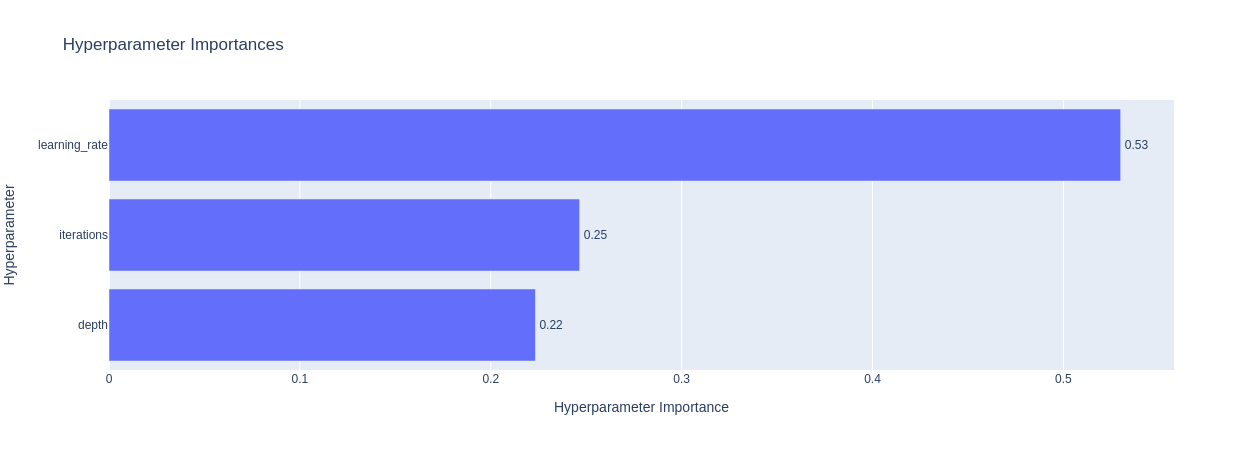

In [197]:
# Построим диаграмму важности гиперпараметров
optuna.visualization.plot_param_importances(study_cb, target_name='MAPE')

Видим, что темп обучения оказывает решающее влияние на результативность моделей. Думаю, что если еще поэксперементировать с этим параметром, то сможем придти к балансу, но метрики на тесте чуть-чуть упадут.

На данный момент считаю лучшим результатом последнюю опробованную модель (iterations=300, learning_rate=0.25, depth=11):
- Train MAE: 113090.075
- Train MAPE: 19.769
- Train R^2: 0.843
- Test MAE: 129800.912
- Test MAPE: 22.801
- Test R^2: 0.782


## Выводы

На этапе моделирования было опробовано много моделей для решения поставленной задачи регрессии. В каждую модель подавали два набора данных: 1 - исходные данные, 2 - данные с логарифмированными числовыми непрерывными признаками и целевым признаком. Второй набор данных всех опробованных моделях показал существенно лучший результат.

Лучшего результата добились с использованием ансамблевого алгоритма CatBoostRegressor:
- минимальное переобучение модели даже на параметрах по умолчанию;
- получили самые высокие метрики MAE, MAPE, R2 (с поправкой на то, что другие ансамблевые алгоритмы не довели до баланса метрик на train и test выборках);
- алгоритм способен работать с категориальными признаками без необходимости их кодировать, что сокращает этап подготовительной работы;
- CatBoost кроме того самый легкий и быстрый из всех опробованных ансамблевых методов, что позволяет быстро получать результат экспериментов и существенно ускоряет работу.


На этом работу над проектом считаю завершенной. Реализация модели в продакшн и сам веб-сервис для тестирования модели находятся в директории web_app.
